# Distance between species trees

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
import dendropy
from dendropy.calculate.treecompare import unweighted_robinson_foulds_distance, weighted_robinson_foulds_distance

In [3]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 12,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

Functions

In [4]:
def shared_taxa(tree1, tree2):
    taxa1 = {node.taxon.label for node in tree1.leaf_node_iter()}
    taxa2 = {node.taxon.label for node in tree2.leaf_node_iter()}
    return list(taxa1.intersection(taxa2)), taxa1, taxa2

In [5]:
def RF_distance(treeA, treeB, norm = True, **kwargs):
    
    treeA_copy, treeB_copy = dendropy.Tree(treeA), dendropy.Tree(treeB)
    
    # Prune trees such that they contain the same taxa, otherwise RF is much larger
    taxa_to_keep, taxa1, taxa2 = shared_taxa(treeA_copy, treeB_copy)
    if len(taxa_to_keep) < len(taxa1) or len(taxa_to_keep) < len(taxa2):
        treeA_copy.retain_taxa_with_labels(taxa_to_keep)
        treeB_copy.retain_taxa_with_labels(taxa_to_keep)
        
    # Update bipartition
    treeA_copy.update_bipartitions()
    treeB_copy.update_bipartitions()
    
    # Assuming trees share the same taxon name space
    rf = unweighted_robinson_foulds_distance(treeA_copy, treeB_copy)
    if norm:
        # Normalize by the maximal possible distance: which is the sum of internal branches
        # between both trees. Alternatively, if both trees are unrooted and binary, the sum
        # is always 2n - 6, where n is the number of tips in the tree.
        max_dist = 2 * len(taxa_to_keep) - 6
        # Number of internal branches
        # n, m = num_internal_branches(treeA_copy), num_internal_branches(treeB_copy)
        if len(taxa_to_keep) > 3:
            rf = rf / max_dist
        else:
            rf = 0.0

    # Ratio between species in inferred to actual species tree
    ratio_sps = len(taxa2) / len(taxa1)
    
    return rf, ratio_sps

## Batch plots

Load data

In [6]:
def load_data_calculate_distance(G, S, copies, noise, ks, ps, replicates, shuffled):
    # To store results
    mean_distances_trees = np.zeros((len(ks), len(ps)))
    std_distances_trees = np.zeros((len(ks), len(ps)))
    mean_ratio_sps = np.zeros((len(ks), len(ps)))
    std_ratio_sps = np.zeros((len(ks), len(ps)))
    # Load data
    for i, k in enumerate(ks):
        for j, p in enumerate(ps):
            taxon_namespace = dendropy.TaxonNamespace()
            distances = np.zeros(len(replicates))
            ratios = np.zeros(len(replicates))
            for rep in replicates:
                if not shuffled:
                    path_inferred_tree = f'./toy/simulations_G_{G}_S_{S}/multicopy_trees_{copies}_copy_noise_{noise}/parsed/nid_sps_k_{k}_p_{p}_rep_{rep}_astralpro2.nwk'
                else:
                    path_inferred_tree = f'./toy/simulations_G_{G}_S_{S}/multicopy_trees_{copies}_copy_noise_{noise}/parsed/nid_sps_shuffled_k_{k}_p_{p}_rep_{rep}_astralpro2.nwk'
                try:
                    # Load actual sps tree
                    actual_tree = dendropy.Tree.get(path = f'./toy/simulations_G_{G}_S_{S}/multicopy_trees_{copies}_copy_noise_{noise}/sps_trees/sps_tree_rep_{rep}.nwk', 
                                                    schema = 'newick', taxon_namespace = taxon_namespace)
                    # Load inferred tree
                    inferred_tree = dendropy.Tree.get(path = path_inferred_tree, 
                                                      schema = 'newick', taxon_namespace = taxon_namespace)
                    # Calculate distance
                    distances[rep], ratios[rep] = RF_distance(actual_tree, inferred_tree)
                except:
                    print(f'\tCannot be loaded. Error. k: {k}, p: {p}, rep :{rep}')
                    distances[rep], ratios[rep] = 0, 0
            # Calculate mean and std of replicates
            mean_distances_trees[i, j] = distances.mean()
            std_distances_trees[i, j] = distances.std()
            mean_ratio_sps[i, j] = ratios.mean()
            std_ratio_sps[i, j] = ratios.std()

    return mean_distances_trees, std_distances_trees, mean_ratio_sps, std_ratio_sps

Parameters from simulation

In [7]:
G = 50
S = 10
replicates = np.arange(0, 25, dtype = int)
ks = np.linspace(1, G - 1, dtype = int, num = 11)
ps = [-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100]
max_copies = [1, 5]
noises = [0.25, 0.5]

In [8]:
%%time
results = {}
results_shuffled = {}
for copies in max_copies:
    results[copies] = {}
    results_shuffled[copies] = {}
    for noise in noises:
        # No shuffled tips --no noise
        mean_distances_trees, std_distances_trees, mean_ratio_sps, std_ratio_sps = load_data_calculate_distance(G, S, copies, noise, ks, ps, replicates, shuffled = False)
        results[copies][0.0] = [mean_distances_trees, std_distances_trees, mean_ratio_sps, std_ratio_sps]
        # Shuffled tips --noise
        mean_distances_trees, std_distances_trees, mean_ratio_sps, std_ratio_sps = load_data_calculate_distance(G, S, copies, noise, ks, ps, replicates, shuffled = True)
        results_shuffled[copies][noise] = [mean_distances_trees, std_distances_trees, mean_ratio_sps, std_ratio_sps]

CPU times: user 41.3 s, sys: 2.44 s, total: 43.7 s
Wall time: 47.9 s


In [9]:
X, Y = np.meshgrid(ps, ks)
norm = mcolors.Normalize(vmin = 0, vmax = 1.0)

/var/folders/kf/c67frc8x3_vbmg84ldmjmbkc0000gq/T/ipykernel_35417/2909450030.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(f'./figures/figure_2A.svg')
/Users/hsecaira/miniconda3/envs/BipNet/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


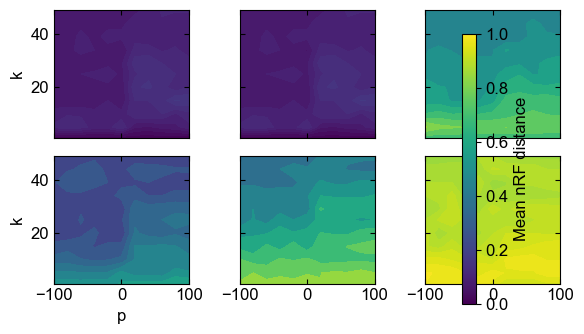

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (6, 3.5),
                        sharex = True, sharey = True)
# 1 copy
copy = 1
im = axes[0, 0].contourf(X, Y, results[copy][0.0][0], norm = norm, levels = 7) # No noise
axes[0, 0].tick_params(top = True, right = True, direction = 'in', which = 'both')
# axes[0, 0].set_title(f'Noise: {0.0}')
j = 1
for noise, data in results_shuffled[copy].items():
    im = axes[0, j].contourf(X, Y, data[0], norm = norm, levels = 7)
    axes[0, j].tick_params(top = True, right = True, direction = 'in', which = 'both')
    # axes[0, j].set_title(f'Noise: {noise}')
    j += 1

# 5 copies
copy = 5
im = axes[1, 0].contourf(X, Y, results[copy][0.0][0], norm = norm, levels = 7) # No noise
axes[1, 0].tick_params(top = True, right = True, direction = 'in', which = 'both')
j = 1
for noise, data in results_shuffled[copy].items():
    im = axes[1, j].contourf(X, Y, data[0], norm = norm, levels = 7)
    axes[1, j].tick_params(top = True, right = True, direction = 'in', which = 'both')
    axes[1, 0].set_xlabel('p')
    j += 1

# Labels
axes[0, 0].set_ylabel('k')
axes[1, 0].set_ylabel('k')
# axes[2, 0].set_ylabel('k')

# Colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(norm = norm, cmap = 'viridis'), ax = axes.ravel().tolist(), shrink = 1.0,
                   label = 'Mean nRF distance')
fig.savefig(f'./figures/figure_2A.svg')

plt.show()

/var/folders/kf/c67frc8x3_vbmg84ldmjmbkc0000gq/T/ipykernel_35417/1448700246.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(f'./figures/figure_S2B.svg')


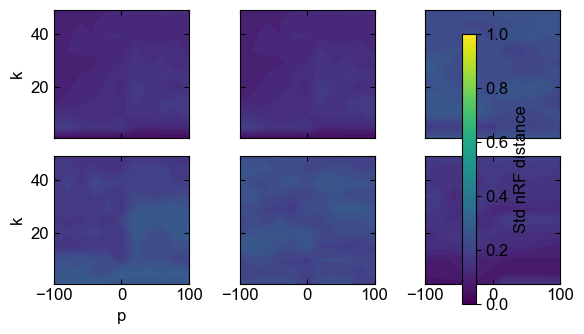

In [11]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (6, 3.5),
                        sharex = True, sharey = True)
# 1 copy
copy = 1
im = axes[0, 0].contourf(X, Y, results[copy][0.0][1], norm = norm, levels = 7) # No noise
axes[0, 0].tick_params(top = True, right = True, direction = 'in', which = 'both')
# axes[0, 0].set_title(f'Noise: {0.0}')
j = 1
for noise, data in results_shuffled[copy].items():
    im = axes[0, j].contourf(X, Y, data[1], norm = norm, levels = 7)
    axes[0, j].tick_params(top = True, right = True, direction = 'in', which = 'both')
    # axes[0, j].set_title(f'Noise: {noise}')
    j += 1

# 5 copies
copy = 5
im = axes[1, 0].contourf(X, Y, results[copy][0.0][1], norm = norm, levels = 7) # No noise
axes[1, 0].tick_params(top = True, right = True, direction = 'in', which = 'both')
j = 1
for noise, data in results_shuffled[copy].items():
    im = axes[1, j].contourf(X, Y, data[1], norm = norm, levels = 7)
    axes[1, j].tick_params(top = True, right = True, direction = 'in', which = 'both')
    axes[1, 0].set_xlabel('p')
    j += 1
    
# Labels
axes[0, 0].set_ylabel('k')
axes[1, 0].set_ylabel('k')
# axes[2, 0].set_ylabel('k')

# Colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(norm = norm, cmap = 'viridis'), ax = axes.ravel().tolist(), shrink = 1.0,
                   label = 'Std nRF distance')

fig.savefig(f'./figures/figure_S2B.svg')

plt.show()